# Исследовательский анализ данных и проверка гипотез Яндекс Афиши

Автор: Чимбир В.И.

Дата: 11.07.2025

# Содержание

1. Цели проекта.
2. Описание данных.
3. Загрузка библиотек, датасетов и знакомство с данными.
4. Предобработка данных.

### Цели проекта

Провести исследовательский анализ пользовательского поведения на сервисе продажи билетов, выявить сезонные и поведенческие паттерны, определить ключевых партнёров и регионы, а также проверить гипотезы об активности пользователей мобильных и стационарных устройств.

### Описание данных

#### **1. Таблица `orders_df` — данные о заказах**
Содержит информацию о бронированиях билетов пользователями.

| Название столбца        | Описание                                                                 |
|-------------------------|--------------------------------------------------------------------------|
| `order_id`              | Уникальный идентификатор заказа                                          |
| `user_id`               | Уникальный идентификатор пользователя                                    |
| `created_dt_msk`        | Дата создания заказа (МСК)                                               |
| `created_ts_msk`        | Дата и время создания заказа (МСК)                                       |
| `event_id`              | Идентификатор мероприятия                                                |
| `cinema_circuit`        | Сеть кинотеатров (если применимо), иначе — `'нет'`                       |
| `age_limit`             | Возрастное ограничение мероприятия                                       |
| `currency_code`         | Валюта оплаты (например, `rub`, `kzt`)                                   |
| `device_type_canonical` | Тип устройства (`mobile`, `desktop` и т.д.)                              |
| `revenue`               | Выручка по заказу                                                        |
| `service_name`          | Название билетного оператора                                             |
| `tickets_count`         | Количество купленных билетов                                             |
| `total`                 | Общая сумма заказа                                                       |
| `days_since_prev`       | Количество дней с предыдущей покупки пользователя (NaN, если первой нет) |

---

#### **2. Таблица `events_df` — информация о мероприятиях**
Содержит сведения о событиях, в том числе регион и площадку проведения.

| Название столбца         | Описание                                                                 |
|--------------------------|--------------------------------------------------------------------------|
| `event_id`               | Уникальный идентификатор мероприятия                                     |
| `event_name`             | Название мероприятия                                                     |
| `event_type_description` | Подробное описание типа мероприятия                                     |
| `event_type_main`        | Основной тип мероприятия (концерт, спектакль и т.д.)                     |
| `organizers`             | Организаторы мероприятия                                                 |
| `region_name`            | Название региона                                                         |
| `city_name`              | Название города                                                          |
| `venue_id`               | Уникальный идентификатор площадки проведения                             |
| `venue_name`             | Название площадки                                                        |
| `venue_address`          | Адрес площадки                                                           |

---

#### **3. Таблица `currency_df` — курс тенге к рублю**
Нужна для конвертации заказов, оплаченных в тенге, в рубли.

| Название столбца | Описание                                      |
|------------------|-----------------------------------------------|
| `nominal`        | Номинал валюты (100 тенге)                    |
| `data`           | Дата курса                                    |
| `curs`           | Курс тенге к рублю за 100 тенге               |
| `cdx`            | Валюта (`kzt`)                                |

---


### Загрузка библиотек, датасетов и знакомство с данными.

In [13]:
# Импортируем необходимые инструменты

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import scipy.stats as stats
from scipy.stats import mannwhitneyu


In [14]:
# Загрузим датасеты

orders_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv', parse_dates=['created_dt_msk', 'created_ts_msk'])
events_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
currency_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv', parse_dates=['data'])

In [15]:
# Познакомимся с данными

# Размерности
print("orders_df:", orders_df.shape)
print("events_df:", events_df.shape)
print("currency_df:", currency_df.shape)

# Быстрый просмотр
display(orders_df.head(3))
display(events_df.head(3))
display(currency_df.head(3))

orders_df: (290849, 14)
events_df: (22427, 11)
currency_df: (357, 4)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt


Промежуточный вывод:

- Все данные соответсвуют описанию и контексту.
- Перед предобработкой данных стоит сразу объединить датафреймы и сделать конвертацию валюты.

### Предобрабокта данных

#### Объединение таблиц

In [4]:
# Объединение заказов и информации о событиях
df = orders_df.merge(events_df, on='event_id', how='inner')

In [5]:
# Выведем общую информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

#### Работа с пропусками

In [6]:
# Проверим датафрейм на пропуски
df.isna().sum()

order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64

Пропуски содержаться только в столбце `days_since_prev`.

| `days_since_prev`       | Количество дней с предыдущей покупки пользователя (NaN, если первой нет) |

С учетом специфики столбца - пропуски логичны, оставляем без изменения.

#### Разбор категориальных значений

In [7]:
# Выводим уникальные значения по всем категориальным колонкам
for col in df.select_dtypes(include='object'):
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False))


user_id:
user_id
0beb8fc0c0a9ce1    10251
18e9aead0a393e7     4368
8187dac4be757a0     4053
3ee7dc2e115847f     3826
7eb4fc207ecc10f     3749
                   ...  
7c0f1cdb436ce17        1
7c158eb0fb1a02c        1
7c1908cb4b166c1        1
7c1cf2fdeea43b2        1
ffff00725179321        1
Name: count, Length: 21933, dtype: int64

cinema_circuit:
cinema_circuit
нет           289213
Другое          1261
КиноСити         122
Киномакс           7
Москино            7
ЦентрФильм         1
Name: count, dtype: int64

currency_code:
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

device_type_canonical:
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

service_name:
service_name
Билеты без проблем        63519
Лови билет!               41124
Билеты в руки             40343
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17774
Весь в билетах            16849
Прачечная                 10273
Край б

In [16]:
# Поиск пропусков
# Список слов, которые считаются отсутствием информации
missing_strings = ['нет', 'неизвестно', 'unknown', 'n/a']

# Функция для проверки наличия мусора в ячейке
def contains_missing_string(cell):
    if isinstance(cell, str):
        return cell.strip().lower() in missing_strings
    return False

# Создаём булевую маску по всему датафрейму
mask = df.applymap(contains_missing_string)

# Посмотрим, сколько таких значений
print("Количество подозрительных значений в датафрейме:", mask.sum().sum())

# Если нужно — вывести сами ячейки
print("Примеры таких строк:")
display(df[mask.any(axis=1)].head())

/var/folders/xr/gthb0scx0c7dbldkflrk1qd00000gn/T/ipykernel_1072/1393940363.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mask = df.applymap(contains_missing_string)


Количество подозрительных значений в датафрейме: 289213
Примеры таких строк:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213,2941,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213,4507,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,...,2f638715-8844-466c-b43f-378a627c419f,выставка,другое,№5049,Североярская область,Озёрск,2,3574,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8"
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,...,10d805d3-9809-4d8a-834e-225b7d03f95d,шоу,стендап,№832,Озернинский край,Родниковецк,240,1896,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8"


In [9]:
no = df['cinema_circuit'][df['cinema_circuit']== 'нет'].count()
print(f"Количество строк со словом 'нет' в столбце cinema_circuit - {no}")

Количество строк со словом 'нет' в столбце cinema_circuit - 289213


Все подозрительные строки (потенциальные пропуски/индикаторы) содержаться в столбце `cinema_circuit`.

Исходя из контекста столбца:

| `cinema_circuit`        | Сеть кинотеатров (если применимо), иначе — `'нет'`                       |

Не считаем это ошибкой и оставляем без изменений.

#### Разбор количественных значений

In [10]:
# Отдельно рублевые и тенговые заказы
df_ru = df[df['currency_code'] == 'rub'].copy()
df_kz = df[df['currency_code'] == 'kzt'].copy()

In [11]:
# Описательные статистики для ключевых количественных столбцов
print("RUB — revenue:")
print(df_ru['revenue'].describe())

print("\nRUB — tickets_count:")
print(df_ru['tickets_count'].describe())

print("\nKZT — revenue:")
print(df_kz['revenue'].describe())

print("\nKZT — tickets_count:")
print(df_kz['tickets_count'].describe())

RUB — revenue:
count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

RUB — tickets_count:
count    285542.000000
mean          2.754159
std           1.171575
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

KZT — revenue:
count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

KZT — tickets_count:
count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         6.000000
Name: tickets_count, dtype: float64


OptionError: "No such keys(s): 'mode.use_inf_as_null'"

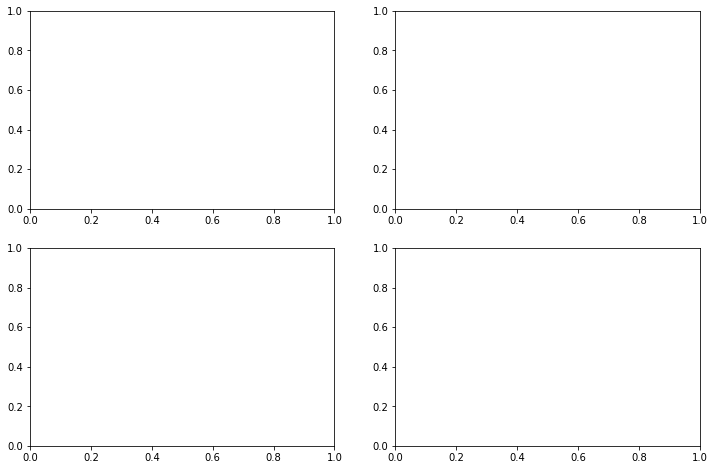

In [12]:
# Постриом гистограммы интересющих столбцов в разрезе валюты

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(df_ru['revenue'], bins=30, kde=True, ax=axs[0,0])
axs[0,0].set_title('RUB — Revenue')

sns.histplot(df_ru['tickets_count'], bins=30, kde=True, ax=axs[0,1])
axs[0,1].set_title('RUB — Tickets Count')

sns.histplot(df_kz['revenue'], bins=30, kde=True, ax=axs[1,0])
axs[1,0].set_title('KZT — Revenue')

sns.histplot(df_kz['tickets_count'], bins=30, kde=True, ax=axs[1,1])
axs[1,1].set_title('KZT — Tickets Count')

plt.tight_layout()
plt.show()

In [ ]:
# Постриом ящики с усами интересющих столбцов в разрезе валюты

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.boxplot(x=df_ru['revenue'], ax=axs[0,0])
axs[0,0].set_title('RUB — Revenue')

sns.boxplot(x=df_ru['tickets_count'], ax=axs[0,1])
axs[0,1].set_title('RUB — Tickets Count')

sns.boxplot(x=df_kz['revenue'], ax=axs[1,0])
axs[1,0].set_title('KZT — Revenue')

sns.boxplot(x=df_kz['tickets_count'], ax=axs[1,1])
axs[1,1].set_title('KZT — Tickets Count')

plt.tight_layout()
plt.show()

- В столбцах `ticket_count` значимых выбросов не обнаружено.
- Столбцы `revenue` имеют ощутимое различие между средним и медианой, стоит отфильтровать обе валюты по 99-му процентилю.
- Столбец `revenue` в рублях содержит отрицательные значения. Это стоит отфильтровать.

In [ ]:
# Отфильтруем данные
quantile_ru = df_ru['revenue'].quantile(0.99)
quantile_kz = df_kz['revenue'].quantile(0.99)

df_ru = df_ru[(df_ru['revenue'] >= 0) & (df_ru['revenue'] < quantile_ru )]
df_kz = df_kz[df_kz['revenue'] < quantile_kz]

# Объединим строки
df_filtered = pd.concat([df_ru, df_kz], ignore_index=True)

# Проверим

print(f"Старый датафрейм содержит {df.shape[0]} строк после фильтрации")
print(f"Обновлённый датафрейм содержит {df_filtered.shape[0]} строк после фильтрации")
print(f"Удалено {df.shape[0] - df_filtered.shape[0]} строк после фильтрации")

На основе описательной статистики, гистограмм и ящиков с усами принято решение отфильтровать датафрейм по определенным показателям. Отфильтровано 20893 строк.

#### Работа с явными и неявными дубликатами

In [ ]:
# Проверим явные дубликаты
print(f"Количестно явных дубликатов в датафрейме - {df_filtered.duplicated().sum()}")
# Проверим дубликаты в первичном ключе
print(f"Количество явных дубликатов в первичном ключе - {df_filtered.duplicated(subset='order_id').sum()}")

In [ ]:
# Список столбцов, по которым будем проверять неявные дубликаты (без order_id)
columns_to_check = [
    'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit',
    'age_limit', 'currency_code', 'device_type_canonical', 'revenue',
    'service_name', 'tickets_count', 'total', 'days_since_prev', 'event_name',
    'event_type_description', 'event_type_main', 'organizers', 'region_name',
    'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address'
]

# Найдём дубликаты (все строки, у которых одинаковые значения по указанным полям)
duplicate_bookings = df[df.duplicated(subset=columns_to_check, keep=False)]

# Посмотрим, сколько и какие
print(f"Найдено потенциальных неявных дубликатов: {duplicate_bookings.shape[0]}")
duplicate_bookings.head()

Наблюдаем 58 дубликатов. Вероятно, это повторные записи, вызванные програмной ошибкой. От таких дубликатов стоит избавиться.

In [ ]:
# Удалим дубликаты
df_cleaned = df_filtered.drop_duplicates(subset=columns_to_check, keep='first')

#### Работа с типами данных

In [ ]:
df_cleaned.info()

Все типы данных соответсвуют контексту столбцов.

#### Рассчет и создание необходимых столбцов

- `revenue_rub` — приведем выручку с заказа к единой валюте — российскому рублю. Для этого используем датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю final_tickets_tenge_df.csv за 2024 год. Значения в рублях представлены для 100 тенге.

- `one_ticket_revenue_rub` — рассчитаем выручку с продажи одного билета на мероприятие.

- `month` — выделим месяц оформления заказа в отдельный столбец.

- `season` — создадим столбец с информацией о сезонности, включая такие категории, как: `лето`, `осень`, `зима`, `весна`.

In [ ]:
# Подготовим currency_df к объединению
currency_df['data'] = pd.to_datetime(currency_df['data']).dt.date

# Добавим колонку с датой  в заказах для дальнейшего объединения
df_cleaned = df_cleaned.copy()
df_cleaned['data'] = df_cleaned['created_dt_msk'].dt.date

In [ ]:
# Отфильтруем заказы в тенге
df_kzt = df_cleaned[df_cleaned['currency_code'] == 'kzt']

# Присоединим курс тенге
df_kzt = df_kzt.merge(currency_df, on='data', how='left')

# Пересчитаем revenue и total в рубли
df_kzt['revenue_rub'] = df_kzt['revenue'] / 100 * df_kzt['curs']

In [ ]:
# Для данных уже в рублях - просто скопируем данные
df_rub = df[df['currency_code'] == 'rub'].copy()
df_rub['revenue_rub'] = df_rub['revenue']


In [ ]:
# Общий датафрейм со всеми заказами в рублях
df_all = pd.concat([df_rub, df_kzt], ignore_index=True)

# Проверим
df_all[['currency_code', 'revenue', 'revenue_rub']].head()

In [ ]:
# Добавим столбец с ценой за один билет
df_all['one_ticket_revenue_rub'] = df_all['revenue_rub'] / df_all['tickets_count']

In [ ]:
# Добавим столбец с месяцем заказа
df_all['month'] = df_all['created_dt_msk'].dt.month

In [ ]:
# Добавим столбец с наименованием сезона
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10, 11]:
        return 'осень'

df_all['season'] = df_all['created_dt_msk'].dt.month.apply(get_season)

In [ ]:
# Оставим только необходимые столбцы
final_columns = [
    'order_id', 'user_id', 'revenue_rub','one_ticket_revenue_rub', 'total', 'created_dt_msk', 'created_ts_msk', 'month','season',  'event_id',
    'cinema_circuit', 'age_limit', 'device_type_canonical',
    'service_name', 'tickets_count', 'days_since_prev', 'event_name',
    'event_type_description', 'event_type_main', 'organizers', 'region_name',
    'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address' ]

df_final = df_all[final_columns]

In [ ]:
# Проверим получившийся датафрейм
df_final.info()

In [ ]:
df_final.head(3)

Промежуточные выводы и итоги:

- Объединили таблицы.
- Проверили данные на пропуски. Значимых для анализа пропусков не обнаружено.
- Разобрали категориальные и количественные значения. Отфильтровано 20893 строк.
- Разобрали явные и неявные дубликаты. Отфильтровано 58 строк.
- Проверили типы данных.
- Сделали конвертацию валюты в рубли. Добавили новый столбец `revenue_rub`.
- Добавили столбцы `month` - месяц заказа и `season` - с информацией о сезонности.


### Исследовательский анализ данных

#### Анализ распределения заказов по сегментам и их сезонные изменения

Анализ дашборда показал, что в данных наблюдается сезонность — осенью количество заказов увеличивается. На стадии исследовательского анализа изучим изменение пользовательской активности или пользовательского интереса в связи с сезонностью.



Задачи:

- Для каждого месяца найдем количество заказов.
- Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.
- Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.


In [ ]:
# Для каждого месяца найдем количество заказов
orders_by_month = df_final['month'].value_counts().sort_index()

In [ ]:
orders_by_month.sort_values(ascending=False).reset_index()

In [ ]:
# Построим столбчатую диограмму
orders_by_month = df_final['month'].value_counts().sort_index()

month_names = [calendar.month_name[i] for i in orders_by_month.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=month_names, y=orders_by_month.values, palette="viridis")
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

- Наблюдаем четкую и ровную динамику роста количества заказов от Июня к Октябрю.

In [ ]:
# Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

# Подготовим функцию для визуализации долей
def compare_seasons(feature):
    summer = df_final[df_final['season'] == 'лето'][feature].value_counts(normalize=True).sort_index()
    autumn = df_final[df_final['season'] == 'осень'][feature].value_counts(normalize=True).sort_index()

    compare_df = pd.DataFrame({'лето': summer, 'осень': autumn}).fillna(0)

    compare_df.plot(kind='bar', figsize=(12, 6), colormap='Set2')
    plt.title(f'Распределение заказов по: {feature}')
    plt.ylabel('Доля заказов')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Построим графики по нужным категориям
compare_seasons('event_type_main')
compare_seasons('device_type_canonical')
compare_seasons('age_limit')

- Летом преобладают такие категории мероприятий как `концерты` и `другое`. Показатели логичные, лето - пара открытых стадионных концертов, различного рода фестивалей.

- Осенью преобладают такие категории мероприятий как `спорт` и `театр`. Так же показатели логичные - осенью начало большинства регулярных сезонов в различных видах спорта.

- По типам устройств в разрезе категорий показатели приблизительно равные. Однако вне категорий видим большой перевес в сторону пользователей с мобильного устройства.

- В летний период наблюдается ужесточение во возрастной категории.

In [ ]:
# Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.
# Группировка по сезону и типу мероприятия
revenue_by_event_season = (
    df_final.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
    .mean()
    .unstack()
    .T
)

# Относительное изменение: (осень - лето) / лето
revenue_change = ((revenue_by_event_season['осень'] - revenue_by_event_season['лето']) / revenue_by_event_season['лето']) * 100

plt.figure(figsize=(12, 6))
revenue_change.sort_values().plot(kind='barh', color='cornflowerblue')
plt.title('Изменение средней выручки с одного билета по типу мероприятия от лета к осени')
plt.xlabel('Изменение в %')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

- Наблюдаем сильное удешевление среднего билета в театр осенью - это объясняет увеличение популярности категории.
- Стендап и выставки становятся дороже - так же логичное падение популярности мероприятий.
- Концерты становтся дешевле, что говорит о стабильном высоком спросе на данную категорию в летний период, не смотря на цену билета.

---

Выводы подраздела:

1. Количество заказов по месяцам:

- Наблюдаем четкую и ровную динамику роста количества заказов от Июня к Октябрю.

2. Сравнение распределения заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу:

- Летом преобладают такие категории мероприятий как `концерты` и `другое`. Показатели логичные, лето - пара открытых стадионных концертов, различного рода фестивалей.

- Осенью преобладают такие категории мероприятий как `спорт` и `театр`. Так же показатели логичные - осенью начало большинства регулярных сезонов в различных видах спорта.

- По типам устройств в разрезе категорий показатели приблизительно равные. Однако вне категорий видим большой перевес в сторону пользователей с мобильного устройства.

- В летний период наблюдается ужесточение во возрастной категории.

3. Изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью:

- Наблюдаем сильное удешевление среднего билета в театр осенью - это объясняет увеличение популярности категории.
- Стендап и выставки становятся дороже - так же логичное падение популярности мероприятий.
- Концерты становтся дешевле, что говорит о стабильном высоком спросе на данную категорию в летний период, не смотря на цену билета.

#### Осенняя активность пользователей

Изучите активность пользователей осенью 2024 года:

- Проанализируем динамику изменений по дням.
- Изучите недельную цикличность.

In [ ]:
# Анализ по дням

# Выделим дату
df_final = df_final.copy()
df_final['date'] = pd.to_datetime(df_final['created_dt_msk']).dt.date

# Оставим в данных только осенний период
df_season = df_final[df_final['season']== 'осень']

# Группировка по дням
daily_stats = (
    df_season.groupby('date')
    .agg(
        orders=('order_id', 'count'),
        dau=('user_id', 'nunique'),
        total_revenue=('revenue_rub', 'sum'),
        total_tickets=('tickets_count', 'sum')
    )
)

# Расчёт дополнительных метрик
daily_stats['orders_per_user'] = daily_stats['orders'] / daily_stats['dau']
daily_stats['avg_ticket_price'] = daily_stats['total_revenue'] / daily_stats['total_tickets']

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
fig.suptitle('Динамика метрик по дням (Осень 2024)', fontsize=16)

# Общее число заказов
axes[0, 0].plot(daily_stats.index, daily_stats['orders'], label='Заказы', color='royalblue')
axes[0, 0].set_title('Общее число заказов')
axes[0, 0].grid(True)

# DAU
axes[0, 1].plot(daily_stats.index, daily_stats['dau'], label='DAU', color='darkorange')
axes[0, 1].set_title('Число уникальных пользователей (DAU)')
axes[0, 1].grid(True)

# Среднее число заказов на одного пользователя
axes[1, 0].plot(daily_stats.index, daily_stats['orders_per_user'], label='Заказы на пользователя', color='seagreen')
axes[1, 0].set_title('Среднее число заказов на пользователя')
axes[1, 0].grid(True)

# Средняя стоимость одного билета
axes[1, 1].plot(daily_stats.index, daily_stats['avg_ticket_price'], label='Цена билета', color='firebrick')
axes[1, 1].set_title('Средняя стоимость одного билета')
axes[1, 1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Проанализируем недельную цикличность
df_season = df_final[df_final['season'] == 'осень'].copy()

# 1. День недели
df_season['day_of_week'] = pd.to_datetime(df_season['created_dt_msk']).dt.dayofweek  # 0 = Пн, 6 = Вс

# 2. Будни / выходные
df_season['day_type'] = df_season['day_of_week'].apply(lambda x: 'будни' if x < 5 else 'выходные')

# 3. Агрегация
orders_by_day = df_season.groupby('day_of_week')['order_id'].count()
dau_by_day = df_season.groupby('day_of_week')['user_id'].nunique()
avg_orders_per_user = orders_by_day / dau_by_day
avg_ticket_price = df_season.groupby('day_of_week')['one_ticket_revenue_rub'].mean()

# Подписи осей
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
x = range(7)

# Визуализация
plt.figure(figsize=(18, 6))
plt.suptitle('Пользовательская активность по дням недели (Осень 2024)', fontsize=16, y=1.05)

plt.subplot(1, 4, 1)
plt.bar(x, orders_by_day, color='skyblue')
plt.xticks(x, days)
plt.title('Количество заказов')

plt.subplot(1, 4, 2)
plt.bar(x, dau_by_day, color='lightgreen')
plt.xticks(x, days)
plt.title('DAU (уникальные пользователи)')

plt.subplot(1, 4, 3)
plt.bar(x, avg_orders_per_user, color='salmon')
plt.xticks(x, days)
plt.title('Среднее число заказов на пользователя')

plt.subplot(1, 4, 4)
plt.bar(x, avg_ticket_price, color='mediumpurple')
plt.xticks(x, days)
plt.title('Средняя стоимость билета')

plt.tight_layout()
plt.show()

# 5. Будни vs Выходные (в том числе средняя стоимость)
summary_by_type = df_season.groupby('day_type').agg({
    'order_id': 'count',
    'user_id': pd.Series.nunique,
    'one_ticket_revenue_rub': 'mean'
}).rename(columns={
    'order_id': 'orders',
    'user_id': 'DAU',
    'one_ticket_revenue_rub': 'avg_ticket_price'
})

summary_by_type['avg_orders_per_user'] = summary_by_type['orders'] / summary_by_type['DAU']
display(summary_by_type)

Промежуточные выводы подраздела:

1. Пользовательская активност по дням:

- Общее число заказов, число уникальных пользователей (DAU) и среднее число заказов на пользователя показывают тенденцию роста с начала наблюдаемого периода.

- Однако графики имеют зубчатую форму с резкими скачками, что говорит о сильной дневной волатильности — вероятно, активность пользователей зависит от факторов вроде выходных, афиш мероприятий или рекламных кампаний.

- Средняя стоимость одного билета также отличается нестабильностью — на графике видно чередование как локальных максимумов, так и провалов. При этом в целом уровень стоимости остаётся стабильным, без выраженной тенденции к росту или падению. 

- Однако в самом конце исследуемого периода наблюдается плавный спад средней стоимости билета.

2. Недельная цикличность:

- Наибольшее количество заказов и среднее число заказов на пользователя приходятся на вторники. Это может указывать на то, что пользователи чаще совершают заказы в начале рабочей недели — возможно, планируют культурные мероприятия заранее.


- Однако при этом наибольшее число уникальных пользователей (DAU) фиксируется в четверг и пятницу — значит в эти дни активируется более широкая аудитория, но с меньшим числом заказов на одного пользователя.


- Наименьшая активность наблюдается в воскресенье и понедельник по всем ключевым метрикам аткивности. Вероятно, это связано с тем, что в воскресенье пользователи отдыхают от цифровой активности, а в понедельник ещё не планируют мероприятия.


- В самый активный пользовательский день - самая низкая средняя стоимость одного билета. По вторникам пользователи заказывают много, но средняя стоимость билета значимо мала. По воскреньям же наоборот - самый неактианвый пользовательский день, однако пользователи предпочитают более дорогие мероприятия.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Динамика метрик и недельная цикличность изучены.

#### Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку:

- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов.
- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

In [ ]:
# Количество уникальных мероприятий и заказов по регионам осенью 2024
region_stats = (
    df_season.groupby('region_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count')
    )
    .sort_values('unique_events', ascending=False)
)

# Добавим доли в процентах с округлением
region_stats['event_share_%'] = round(region_stats['unique_events'] / region_stats['unique_events'].sum() * 100, 2)
region_stats['order_share_%'] = round(region_stats['total_orders'] / region_stats['total_orders'].sum() * 100, 2)

# Вывод топ-10
display(region_stats.head(10))

In [ ]:
# Постриом визуализацию для топ-10
region_stats['unique_events'].sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(10, 6), color='slateblue')
plt.title('Топ-10 регионов по числу уникальных мероприятий')
plt.xlabel('Количество мероприятий')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Статистика по партнёрам
partner_stats = (
    df_season.groupby('service_name')
    .agg(
        unique_events=('event_id', 'nunique'),
        total_orders=('order_id', 'count'),
        total_revenue=('revenue_rub', 'sum')
    )
    .sort_values('total_orders', ascending=False)
)

# Доли и округления
partner_stats['order_share_%'] = round(partner_stats['total_orders'] / partner_stats['total_orders'].sum() * 100, 2)
partner_stats['revenue_share_%'] = round(partner_stats['total_revenue'] / partner_stats['total_revenue'].sum() * 100, 2)
partner_stats['total_revenue'] = round(partner_stats['total_revenue'], 2)

# Вывод топ-10
partner_stats.head(10)

In [ ]:
# Визуализируем статистику по партнерам

partner_stats['total_revenue'].sort_values(ascending=True).tail(10).plot(kind='barh', figsize=(10, 6), color='darkorange')
plt.title('Топ-10 партнёров по выручке')
plt.xlabel('Выручка (₽)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

Промежуточные выводы подраздела:

1. Статистика по регионам:

-  Каменевский регион: Лидер по количеству уникальных мероприятий: 5983 (≈25% от всех мероприятий). Формирует наибольшую долю заказов — 91 058 заказов (≈28% от общего количества). Это говорит о высокой вовлечённости аудитории и высокой конверсии мероприятий в заказы.
  
- Североярская область: Второй по числу мероприятий (3814), но при этом доля заказов (16%) немного отстаёт от доли событий (12%). Возможное объяснение: слабее интерес аудитории или менее популярные события.

- Светополянский округ и Речиновская область: Относительно высокая доля мероприятий, но низкая доля заказов. Например, Светополянский округ — ~4.8% мероприятий, но только ~2.8% заказов. Это говорит о низкой окупаемости мероприятий или слабом спросе.

- Имеем четкую лидерсую группу из двух регионов. Остальные регионы значительно уступают в долевых показателях.

2. Статистика по партнерам:

- Разные партнеры занимают разные ниши.

- Часть партенров рабоает на массовость и объем, например, Билеты без проблем - ~19% всех мероприятий, но доля выручки лишь ~15%

- Часть работают с дорогими мероприятиями и приносят диспропорционально высокую выручку (Мой билет, Облачко, Весь в билетах).


### Статистический анализ данных

Проверим две гипотезы относительно активности пользователей мобильных и стационарных устройств в осенний период:



In [ ]:
# Подготовим данные

# Осенний период
autumn_df = df_final[df_final['season'] == 'осень']

# Мобильные и стационарные устройства
mobile_df = autumn_df[autumn_df['device_type_canonical'] == 'mobile']
desktop_df = autumn_df[autumn_df['device_type_canonical'] == 'desktop']

#### Гипотеза: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

`H₀ (нулевая гипотеза)`: Среднее количество заказов на пользователя у мобильного приложения `не больше` чем у стационарного устройства

`H₁ (альтернативная гипотеза)`: Среднее количество заказов на пользователя у мобильного приложения `больше` чем у стационарного устройства

In [ ]:
# Подготовка данных

# Кол-во заказов на одного пользователя
orders_mobile = mobile_df.groupby('user_id')['order_id'].nunique()
orders_desktop = desktop_df.groupby('user_id')['order_id'].nunique()

print(orders_mobile)


In [ ]:
# Проверим распределения
plt.figure(figsize=(14,6))
sns.histplot(orders_mobile, color='blue', label='Mobile', kde=False, stat='density', bins=30, alpha=0.5)
sns.histplot(orders_desktop, color='green', label='Desktop', kde=False, stat='density', bins=30, alpha=0.5)
plt.legend()
plt.title('Распределение заказов на одного пользователя')
plt.xlabel('Количество заказов')
plt.show()

In [ ]:
# Построим Q-Q plot для категорий

# Для мобильных пользователей
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(orders_mobile, dist="norm", plot=plt)
plt.title("Q-Q plot для заказов мобильных пользователей")

# Для десктопных пользователей
plt.subplot(1, 2, 2)
stats.probplot(orders_desktop, dist="norm", plot=plt)
plt.title("Q-Q plot для заказов десктопных пользователей")

plt.tight_layout()
plt.show()

In [ ]:
# Визуализация - boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=[orders_mobile, orders_desktop], showfliers=True)
plt.xticks([0,1], ['Mobile', 'Desktop'])
plt.title('Сравнение распределения заказов на пользователя')
plt.ylabel('Количество заказов')
plt.show()

Распределения ненормальные, так же наблюдаем немаленькое количесвто выбросов. Для проверки гипотезы выбираем непараметрический тест Манна-Уитни, который менее чуствителен к выбросам.

In [ ]:
# Посчитаем средние и медианы
mean_mobile = np.mean(orders_mobile)
mean_desktop = np.mean(orders_desktop)
median_mobile = np.median(orders_mobile)
median_desktop = np.median(orders_desktop)

print(f"Среднее (мобильные): {mean_mobile:.2f}, медиана: {median_mobile}")
print(f"Среднее (десктоп): {mean_desktop:.2f}, медиана: {median_desktop}")

In [ ]:
# Визуализация - boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=[orders_mobile, orders_desktop], showfliers=False)
plt.xticks([0,1], ['Mobile', 'Desktop'])
plt.title('Сравнение распределения заказов на пользователя')
plt.ylabel('Количество заказов')
plt.show()

In [ ]:
# Статистический тест Манна-Уитни с альтернативой "greater" (мобильные > десктоп)
stat, p_value = mannwhitneyu(orders_mobile, orders_desktop, alternative='greater')
print(f"p-value (one-sided): {p_value:.4f}")

# Интерпретация
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: среднее количество заказов у мобильных статистически значимо больше, чем у десктопных.")
else:
    print("Нет оснований отвергать нулевую гипотезу: недостаточно доказательств, что мобильные активнее.")

#### Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

`H₀`:  Среднее время между заказами пользователей мобильных приложений __не выше__ по сравнению с пользователями стационарных устройств

`H₁`:  Среднее время между заказами пользователей мобильных приложений __выше__ по сравнению с пользователями стационарных устройств

In [ ]:
# Подготовим данные

# Разница между соседними заказами у одного пользователя
#def get_avg_days(df):
 ##      df.sort_values(['user_id', 'created_dt_msk'])
#        .groupby('user_id')['created_dt_msk']
#        .apply(lambda x: x.diff().dt.days.dropna().mean())
#    )

#avg_days_mobile = get_avg_days(mobile_df).dropna()
#avg_days_desktop = get_avg_days(desktop_df).dropna()

In [ ]:
# Удалим пропуски
mobile_days = mobile_df['days_since_prev'].dropna()
desktop_days = desktop_df['days_since_prev'].dropna()

In [ ]:
# Визуализация — boxplot с выбросами
plt.figure(figsize=(8, 5))
sns.boxplot(data=[mobile_days, desktop_days], showfliers=True)
plt.xticks([0, 1], ['Mobile', 'Desktop'])
plt.title('Распределение времени между заказами (дни)')
plt.ylabel('Дни с предыдущего заказа')
plt.show()

In [ ]:
# Построим гистограммы
plt.figure(figsize=(10, 5))
plt.hist(mobile_days, bins=30, color='blue', alpha=0.6, label='Mobile', density=True)
plt.hist(desktop_days, bins=30, color='green', alpha=0.6, label='Desktop', density=True)
plt.title('Распределение времени между заказами (дни)')
plt.xlabel('Дни с предыдущего заказа')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# Описательная статистика
print('Среднее время между заказами (дни):')
print(f"- Mobile: {mobile_days.mean():.2f}")
print(f"- Desktop: {desktop_days.mean():.2f}\n")

print('Медиана времени между заказами (дни):')
print(f"- Mobile: {mobile_days.median():.2f}")
print(f"- Desktop: {desktop_days.median():.2f}")

In [ ]:
# Визуализация — boxplot с выбросами
plt.figure(figsize=(8, 5))
sns.boxplot(data=[mobile_days, desktop_days], showfliers=False)
plt.xticks([0, 1], ['Mobile', 'Desktop'])
plt.title('Распределение времени между заказами (дни)')
plt.ylabel('Дни с предыдущего заказа')
plt.tight_layout()
plt.show()

Наблюдаем положительную скошенность. Рарспределения ненормальные, так же наблюдаем большое количество выбросов. Для проверки выбираем непараметрический тест Манна-Уитни, который менее чуствителен к выбросам.

In [ ]:
 # Статистический тест Манна-Уитни
stat, p_value = mannwhitneyu(mobile_days, desktop_days, alternative='greater')
print(f"p-value (one-sided): {p_value:.4f}")

# 4. Интерпретация
if p_value < 0.05:
    print("Отвергаем нулевую гипотезу: у мобильных пользователей интервал между заказами статистически больше.")
else:
    print("Нет оснований отвергать H₀: различия в интервалах не подтверждены статистически.")

Промежуточные выводы по гипотезам:

	1.	Гипотеза 1:
Пользователи мобильных устройств в среднем делают больше заказов, чем пользователи десктопов.
Статистически значимое различие подтверждено (p-value < 0.05).

	2.	Гипотеза 2:
Интервал между заказами у мобильных пользователей в среднем больше, чем у десктопных.
Статистически значимое различие подтверждено (p-value < 0.05).


### Общий вывод и рекомендации

#### Информация о данных

В ходе проекта были проанализированы данные о заказах билетов на мероприятия из сервиса, действующего на территории России и Казахстана. Данные охватывают период с июня по октябрь 2024 года и содержат информацию о событиях, пользователях, устройствах, бронированиях и билетных партнёрах. Также была доступна таблица с курсами валют для приведения выручки к рублёвому эквиваленту. В общей сложности данные включают десятки тысяч заказов, охватывающих сотни городов, партнёров и различных типов мероприятий.

#### Проделанная работа

    1. Предобработка данных:
    
- Проверили типы данных, проанализировали пропуски, удалили неявные дубликаты, отфильтровали выбросы, проверили значения рассчитали и добавили необходимые новые столбцы.


    2. Исследователький анализ данных:
    
- Провели анализ распределения заказов по сегментам и их сезонные изменения
- Изучили  осеннюю активность пользователей
- Проанализирвоали популярность событий в разрезе партнеров и регионов


    3. Статистический анализ данных
   
- С помощью тестов проверили две гипотезы по активности среди пользователей мобильным декстопным устройсвами.

#### Выводы и рекомендации

**Выводы**

**1. Предобработка данных**

- Данные обработаны. Критических ошибок, способных повлиять на анализ, не осталось.   


---

**2. Исследовательский анализ данных**

**📈 Динамика заказов и категорий мероприятий**

- Наблюдается чёткая динамика роста количества заказов с июня по октябрь 2024 года.  
- Летом преобладают категории мероприятий: `концерты` и `другое`.  
- Осенью доминируют категории: `спорт` и `театр`.  
- По типам устройств — приблизительное равенство в категориях, но в целом **преобладают мобильные пользователи**.  
- Летом наблюдается ужесточение возрастных категорий.  
- Театр осенью становится дешевле → рост популярности.  
- Стендап и выставки — дороже → вероятное снижение интереса.  
- Концерты дешевеют, но остаются популярными — спрос стабильно высок.

---

**3. Динамика пользовательской активности по дням**

- Кол-во заказов, DAU и среднее кол-во заказов на пользователя стабильно растут.  
- Графики «зубчатые» — есть резкие скачки и спады, вероятно, влияние внешних факторов.  
- Средняя стоимость билета нестабильна,резкие скачки вниз, но в целом без тренда. В конце — **спад**.

---

**4. Недельная цикличность**

- Пик заказов и заказов на пользователя — **вторник**.  
- Пик DAU — **четверг** (больше пользователей, но меньше заказов на одного).  
- Наименьшая активность — **воскресенье и понедельник**.

---

**5. География событий**

📍 **Регионы:**

- **Каменевский регион** — лидер (25% мероприятий, 28% заказов).  
- **Североярская область** — 16% мероприятий, 12% заказов.  
- **Светополянский округ**, **Речиновская область** — много мероприятий, мало заказов → **низкая эффективность**.

🤝 **Партнёры:**

- «Билеты без проблем» — масштаб, но не максимальная выручка.  
- «Мой билет», «Облачко», «Весь в билетах» — меньший объём, но большая выручка.

---

**6. Статистический анализ**

**Гипотеза 1:**  
Мобильные пользователи делают больше заказов → ✅ Подтверждено (p-value < 0.05)

**Гипотеза 2:**  
Интервал между заказами больше у мобильных → ✅ Подтверждено (p-value < 0.05)

---

**Рекомендации**

- Развивать мобильное приложение: больше заказов, выше вовлечённость.  
- Сосредоточиться на Каменевском и Североярском регионах.  
- Пересмотреть подход к регионам с низкой конверсией.  
- Продолжать ценовые эксперименты — особенно с театром, выставками и стендапом.  
- Учитывать недельную цикличность в маркетинге — вторник и пятница как точки роста.    
- Планировать пиковые кампании на осенний период.
- Обратить внимание на популярность концертов и фестивалей в летний период.

---

